In [1]:
# code based on the freely available freia package
# https://github.com/VLL-HD/FrEIA

In [9]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)

load_model = False

labels_y = np.load('labels_y.npy')
labels_y_test = np.load('labels_y_test.npy')
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
indices_0 = np.where(labels_y == 0.)
indices_8 = np.where(labels_y == 8.)

x_train_0 = x_train[indices_0]
x_train_8 = x_train[indices_8]

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()
perm = torch.randperm(len(x_test))[:1000]

inv_perm  = []
for i in range(len(x_test)):
    if i not in perm:
        inv_perm.append(i)
        
x_val = x_test[inv_perm]
y_val = y_test[inv_perm]

x_test = x_test[perm]
y_test = y_test[perm]
labels_y_test = labels_y_test[perm]

In [10]:
x_train = x_train.reshape(len(x_train),784)
y_train = y_train.reshape(len(y_train),168)

x_test = x_test.reshape(len(x_test),784)
y_test = y_test.reshape(len(y_test),168)

x_val = x_val.reshape(len(x_val),784)
y_val = y_val.reshape(len(y_val),168)

In [11]:
ndim_tot = 784
ndim_x = 784
ndim_y = 168
ndim_z = 14

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                         nn.Linear(512,  c_out))

nodes = [InputNode(ndim_tot, name='input')]

for k in range(5):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':3.0},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))

nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False).to(device)
# implicit assumption that dim_x = dim_y + dim_z (gaussian padding)

prob_net = nn.Sequential(nn.Linear(168,64), nn.ReLU(),
                        nn.Linear(64,2), nn.Softmax(dim = 1)).to(device)

trainable_parameters = [p for p in model.parameters() if p.requires_grad]
if load_model == False:
    for param in trainable_parameters:
        param.data = 0.043*torch.randn_like(param)

    with torch.no_grad():
        mean1 = torch.mean(model(x_train_0[:1000].to(device))[:,:14], dim = 0).view(1,ndim_z)
        mean2 = torch.mean(model(x_train_8[:1000].to(device))[:,:14], dim = 0).view(1,ndim_z)


    print(mean1)
    print(mean2)
    print(torch.sum((mean1-mean2)**2))

    mean1 = 4*mean1
    mean2 = 4*mean2

if load_model: 
    # load pretrained model
    model.load_state_dict(torch.load('inpainting_inn.pt'))
    prob_net.load_state_dict(torch.load('inpainting_prob.pt'))
    

tensor([[ 0.3187,  0.0212, -0.8973, -0.7751,  0.1953, -0.6651,  0.4720,  1.7763,
         -0.3287,  0.7755,  0.4502,  0.9136, -0.3690,  0.1816]],
       device='cuda:0')
tensor([[-0.3810, -0.3225, -0.7623, -0.3519,  1.1874, -0.2280,  0.5318,  1.0056,
         -0.2893,  0.3094, -0.3936,  1.2904,  0.2613,  0.1012]],
       device='cuda:0')
tensor(4.0545, device='cuda:0')


In [12]:
# Training parameters
n_epochs = 500
batch_size = 1200

lr_INN = 1e-3
lr_prob = 1e-3
l2_reg = 1e-4
# relative weighting of losses:
lambd_predict = 100. 
lambd_latent = 150.
lambd_rev = 0.
lambd_pad = 0.

y_noise_scale = 7e-2
zeros_noise_scale = 0.

Loss_ramp = False
# Parameters for GMM
gum = torch.distributions.gumbel.Gumbel(torch.tensor([0.0]), torch.tensor([1.0]), validate_args=None)
temp = 0.1
no_gaussians = 2
if load_model:
    means = torch.load('means.pt')
else:
    means = torch.cat((mean1,mean2),1).to(device).view(no_gaussians, ndim_z)
# standard deviation of Gaussian
scale = .6

trainable_parameters = [p for p in model.parameters() if p.requires_grad]
prob_par = [p for p in prob_net.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(trainable_parameters, lr=lr_INN, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=l2_reg)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.4)



optimizer2 = torch.optim.Adam(prob_par, lr= lr_prob)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=100, gamma=0.4)



def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for a in [0.05, 0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1

    return torch.mean(XX + YY - 2.*XY)


def fit(input, target):
    return torch.mean((input - target)**2)


loss_backward = MMD_multiscale
loss_latent = MMD_multiscale
loss_fit = fit

In [13]:
def train(i_epoch=0):
    perm = torch.randperm(len(x_train))
    for k in range(int(len(x_train)/batch_size)):
        model.train()
        l_tot = 0
        # If MMD on x-space is present from the start, the model can get stuck.
        # Instead, ramp it up exponetially.
        if Loss_ramp:
            loss_factor = min(1., 2. * 0.002**(1. - (float(i_epoch) / n_epochs)))
        else:
            loss_factor = 1.
        perm2 = perm[k*batch_size:(k+1)*batch_size]
        x = x_train[perm2]
        y = y_train[perm2]
        x, y = x.to(device), y.to(device)
        x+= y_noise_scale * torch.randn(batch_size, ndim_x, dtype=torch.float, device=device)

        optimizer.zero_grad()          
        optimizer2.zero_grad()

        #Pass and create data
        y_clean = y.clone()
        pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                    ndim_x, device=device)
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                     ndim_y - ndim_z, device=device)
        y = y + y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device)

        # Gumbel trick for sampling z
        probs = prob_net(y)
        gumbs = gum.sample((len(y),no_gaussians)).to(device).view(len(y),no_gaussians)
        logits = gumbs+torch.log(probs)
        maxi,index = torch.max(logits, dim = 1)
        maxi = maxi.view(len(maxi),1)
        maxi = torch.cat((maxi,maxi),1)
        #logits = torch.exp(logits/temp)/torch.sum(torch.exp(logits/temp), dim = 1).view(len(y),1)
        logits = torch.exp((logits-maxi)/temp)/torch.sum(torch.exp((logits-maxi)/temp), dim = 1).view(len(y),1)
        # Create an array of all possible mixture components with all means
        norms = torch.zeros(len(y),no_gaussians,ndim_z,device = device)+means
        # Enlarge logits array to fit the size of norms
        #logits2 = torch.cat((logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1)), dim = 2) 
        logits2  = torch.zeros(len(y),no_gaussians,ndim_z, device = device) 
        logits2 += logits.view(len(y),no_gaussians,1)
        # linearly combinate the mixture components
        q = torch.sum(logits2*norms, dim = 1).view(len(y),ndim_z)
        # put it into z
        z = q+scale*torch.randn(len(y),ndim_z, device = device)

        # Pad vectors
        x, y = (torch.cat((x, pad_x),  dim=1),torch.cat((z, pad_yz, y),dim=1))

        # Forward step
        output = model(x)
        # Shorten output, and remove gradients wrt y, for latent loss
        y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)
        l = lambd_predict * loss_fit(output[:, ndim_z:], y[:, ndim_z:])
        output_block_grad = torch.cat((output[:, :ndim_z],
                                       output[:, -ndim_y:].data), dim=1)
        l += lambd_latent * loss_latent(output_block_grad, y_short)

        l_tot += l.data.item()
        l.backward()

        # Backward step
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
        y = y_clean + y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device)

        probs = prob_net(y)
        gumbs = gum.sample((len(y),no_gaussians)).to(device).view(len(y),no_gaussians)
        logits = gumbs+torch.log(probs)
        maxi,index = torch.max(logits, dim = 1)
        maxi = maxi.view(len(maxi),1)
        maxi = torch.cat((maxi,maxi),1)
        #logits = torch.exp(logits/temp)/torch.sum(torch.exp(logits/temp), dim = 1).view(len(y),1)
        logits = torch.exp((logits-maxi)/temp)/torch.sum(torch.exp((logits-maxi)/temp), dim = 1).view(len(y),1)
        # Create an array of all possible mixture components with all means
        norms = torch.zeros(len(y),no_gaussians,ndim_z,device = device)+means
        # Enlarge logits array to fit the size of norms
        #logits2 = torch.cat((logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1)), dim = 2) 
        logits2 = torch.zeros(len(y),no_gaussians,ndim_z, device = device) 
        logits2 += logits.view(len(y),no_gaussians,1)
        # linearly combinate the mixture components
        q = torch.sum(logits2*norms, dim = 1).view(len(y),ndim_z)
        # put it into z
        z = q+scale*torch.randn(len(y),ndim_z, device = device)

        orig_z_perturbed = (output.data[:, :ndim_z] + y_noise_scale * torch.randn(batch_size, ndim_z, device=device))
        y_rev = torch.cat((orig_z_perturbed, pad_yz, y), dim=1)
        output_rev = model(y_rev, rev=True)              
        y_rev_rand = torch.cat((z, pad_yz,y), dim=1)
        output_rev_rand = model(y_rev_rand, rev=True)
        l_rev = lambd_rev * loss_factor * loss_backward(
            output_rev_rand[:, :ndim_x],x[:, :ndim_x])

        l_rev += lambd_predict * loss_fit(output_rev, x)
        l_tot += l_rev.data.item()
        l_rev.backward()

        # Clamping and optimizer steps
        for p in model.parameters():
            p.grad.data.clamp_(-15.00, 15.00)
        

        for p in prob_net.parameters():
            p.grad.data.clamp_(-15.00,15.00)

        optimizer.step()
        optimizer2.step()
    scheduler.step()
    scheduler2.step()


    return l_tot


In [14]:
def test(i_epoch=0):
    perm = torch.randperm(len(x_val))[:500]
    l_tot = 0

    x = x_val[perm]
    y = y_val[perm]
    x, y = x.to(device), y.to(device)

    #Pass and create data
    y_clean = y.clone()
    pad_x = zeros_noise_scale * torch.randn(500, ndim_tot -
                                                ndim_x, device=device)
    pad_yz = zeros_noise_scale * torch.randn(500, ndim_tot -
                                                 ndim_y - ndim_z, device=device)

    # Gumbel trick for sampling z
    probs = prob_net(y)
    gumbs = gum.sample((len(y),no_gaussians)).to(device).view(len(y),no_gaussians)
    logits = gumbs+torch.log(probs)
    maxi,index = torch.max(logits, dim = 1)
    maxi = maxi.view(len(maxi),1)
    maxi = torch.cat((maxi,maxi),1)
    #logits = torch.exp(logits/temp)/torch.sum(torch.exp(logits/temp), dim = 1).view(len(y),1)
    logits = torch.exp((logits-maxi)/temp)/torch.sum(torch.exp((logits-maxi)/temp), dim = 1).view(len(y),1)
    # Create an array of all possible mixture components with all means
    norms = torch.zeros(len(y),no_gaussians,ndim_z,device = device)+means
    # Enlarge logits array to fit the size of norms
    #logits2 = torch.cat((logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1)), dim = 2) 
    logits2  = torch.zeros(len(y),no_gaussians,ndim_z, device = device) 
    logits2 += logits.view(len(y),no_gaussians,1)
    # linearly combinate the mixture components
    q = torch.sum(logits2*norms, dim = 1).view(len(y),ndim_z)
    # put it into z
    z = q+scale*torch.randn(len(y),ndim_z, device = device)

    # Pad vectors
    x, y = (torch.cat((x, pad_x),  dim=1),torch.cat((z, pad_yz, y),dim=1))

    # Forward step
    output = model(x)
    # Shorten output, and remove gradients wrt y, for latent loss
    y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)
    l = lambd_predict * loss_fit(output[:, ndim_z:], y[:, ndim_z:])
    output_block_grad = torch.cat((output[:, :ndim_z],
                                   output[:, -ndim_y:].data), dim=1)
    l += lambd_latent * loss_latent(output_block_grad, y_short)
    l_tot += l.data.item()
    # Backward step
    pad_yz = zeros_noise_scale * torch.randn(500, ndim_tot -
                                             ndim_y - ndim_z, device=device)
    y = y_clean


    probs = prob_net(y)
    gumbs = gum.sample((len(y),no_gaussians)).to(device).view(len(y),no_gaussians)
    logits = gumbs+torch.log(probs)
    maxi,index = torch.max(logits, dim = 1)
    maxi = maxi.view(len(maxi),1)
    maxi = torch.cat((maxi,maxi),1)
    #logits = torch.exp(logits/temp)/torch.sum(torch.exp(logits/temp), dim = 1).view(len(y),1)
    logits = torch.exp((logits-maxi)/temp)/torch.sum(torch.exp((logits-maxi)/temp), dim = 1).view(len(y),1)
    # Create an array of all possible mixture components with all means
    norms = torch.zeros(len(y),no_gaussians,ndim_z,device = device)+means
    # Enlarge logits array to fit the size of norms
    #logits2 = torch.cat((logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1)), dim = 2) 
    logits2 = torch.zeros(len(y),no_gaussians,ndim_z, device = device) 
    logits2 += logits.view(len(y),no_gaussians,1)
    # linearly combinate the mixture components
    q = torch.sum(logits2*norms, dim = 1).view(len(y),ndim_z)
    # put it into z
    z = q+scale*torch.randn(len(y),ndim_z, device = device)

    orig_z_perturbed = (output.data[:, :ndim_z] + y_noise_scale * torch.randn(500, ndim_z, device=device))
    y_rev = torch.cat((orig_z_perturbed, pad_yz, y), dim=1)
    output_rev = model(y_rev, rev=True)              
    y_rev_rand = torch.cat((z, pad_yz,y), dim=1)
    output_rev_rand = model(y_rev_rand, rev=True)
    l_rev = lambd_rev * loss_backward(
        output_rev_rand[:, :ndim_x],x[:, :ndim_x])

    l_rev += lambd_predict * loss_fit(output_rev, x)
    l_tot += l_rev.data.item()
    return l_tot

In [15]:
# no need to run when loading model

for i in range(n_epochs):
    train(i)
    if i%10 == 0:
        print(i)
        print(test(i))

0
22.485026359558105
10
6.687471389770508
20
6.067348480224609
30
5.237604379653931
40
5.5353803634643555
50
5.196822643280029
60
5.18030047416687
70
5.202934503555298
80
5.087857961654663
90
4.975849628448486
100
4.87096643447876
110
4.840364217758179
120
4.717806577682495
130
4.922637939453125
140
4.807814121246338
150
4.793555021286011
160
4.894291400909424
170
5.098556995391846
180
4.943959712982178
190
4.861870288848877
200
4.764277458190918
210
4.797903537750244
220
4.917746067047119
230
4.884798526763916
240
4.81255316734314
250
4.979633569717407
260
5.0014967918396
270
4.888291835784912
280
4.977632999420166
290
4.938556671142578
300
4.98610782623291
310
5.042932748794556
320
4.950484275817871
330
5.020989894866943
340
4.945399761199951
350
5.057751178741455
360
5.061047077178955
370
4.9780542850494385
380
5.084450721740723
390
4.98621678352356
400
5.039304971694946
410
5.122577428817749
420
4.968193054199219
430
4.980361223220825
440
5.10406756401062
450
5.045659065246582
460


tensor([[0.8342, 0.1658],
        [0.8342, 0.1658],
        [0.8342, 0.1658],
        [0.8342, 0.1658],
        [0.8342, 0.1658],
        [0.8342, 0.1658],
        [0.8342, 0.1658],
        [0.8342, 0.1658],
        [0.8342, 0.1658],
        [0.8342, 0.1658],
        [0.8342, 0.1658],
        [0.8342, 0.1658],
        [0.8342, 0.1658],
        [0.8342, 0.1658]], device='cuda:0', grad_fn=<SoftmaxBackward>)
0
0
0
0
0
1
0
0
0
0
0
0
0
0


<IPython.core.display.Javascript object>


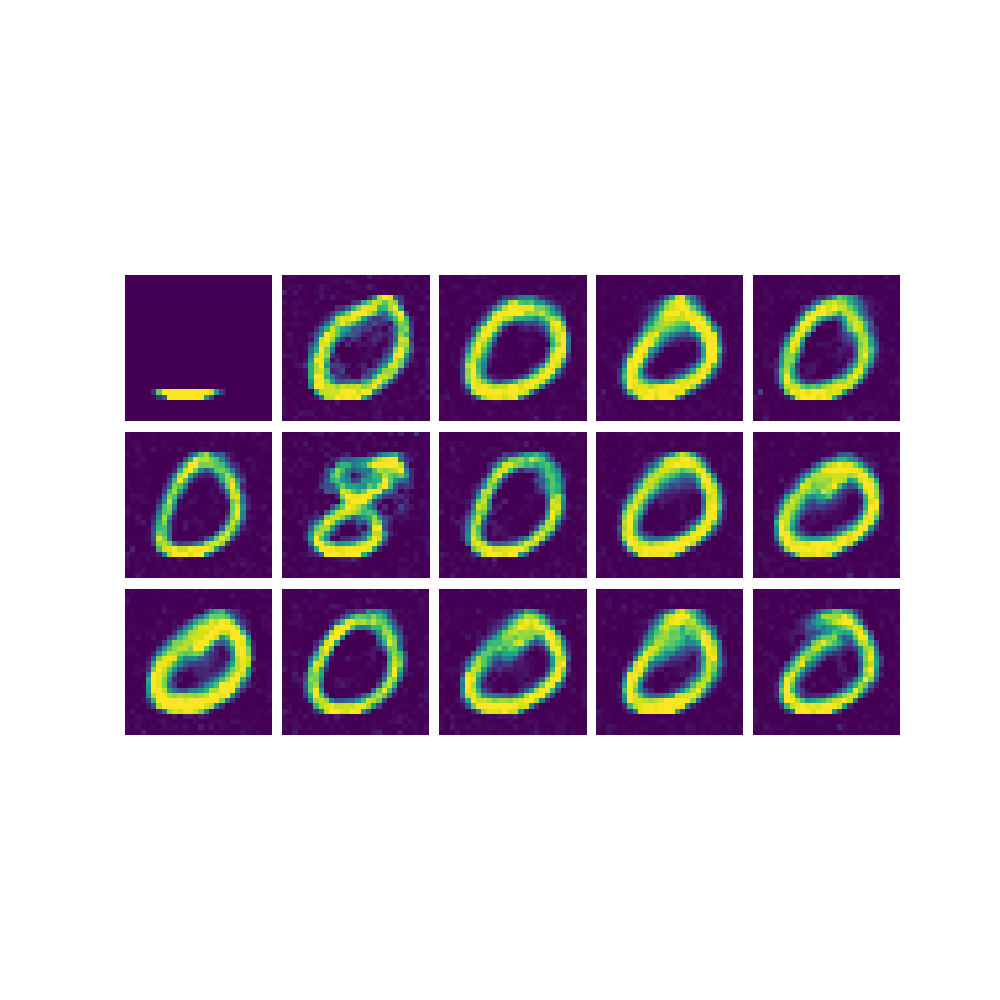

(15, 784)


In [16]:
import random 
from mpl_toolkits.axes_grid1 import ImageGrid
# sample from the conditional distributions, conditioned on the "sample"-th test sample y

sample = 23
z = torch.randn(14, ndim_z, device = device)*scale
y = y_test[sample].reshape(ndim_y)
ys = torch.zeros(14,ndim_y, device = device)
ys += y.to(device)

probs = prob_net(ys)
print(probs)

for i in range(len(z)):
    rand = random.random() 
    if rand < probs[i][0].cpu():
        print(0)
        z[i] += means[0]
    else:
        print(1)
        z[i] += means[1]
inp = torch.cat((z, torch.zeros(14,ndim_tot-ndim_y-ndim_z, device = device),ys),1)


output = model(inp, rev = True).cpu().detach().numpy()[:,:784]

fig = plt.figure(figsize=(10., 10.))

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

y = torch.cat((torch.zeros(1,784-168),y.reshape(1,168)),1)
pics = np.concatenate((y,output),0)

print(pics.shape)
for ax, im in zip(grid, pics):
    ax.imshow(im.reshape(28,28), vmin = 0., vmax = 1.)
    ax.axis('off')
    
#plt.savefig('23_samples.png', bbox_inches = 'tight')
    

<IPython.core.display.Javascript object>


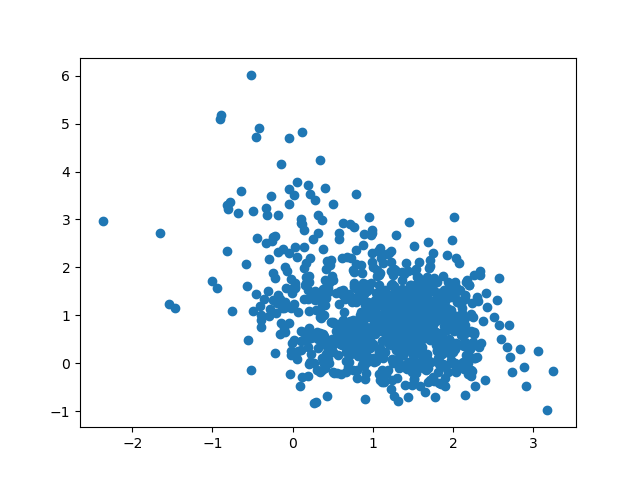

<IPython.core.display.Javascript object>


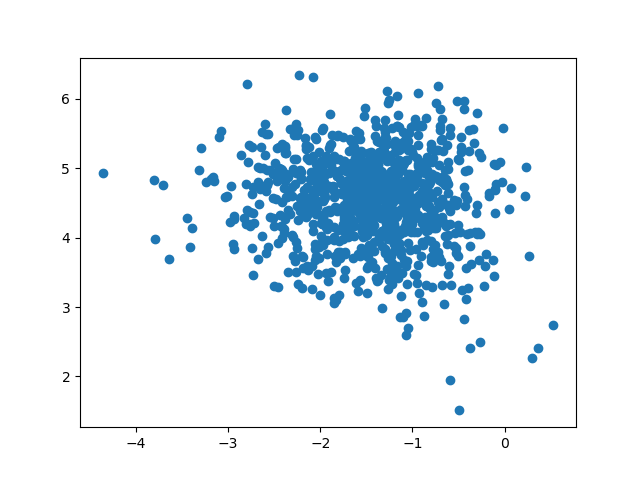

In [10]:
# check the latent fit for separation

plt.figure()
y1 = model(x_train_0[:1000].to(device))[:,:14].cpu().data.numpy()[:,0]
y2 = model(x_train_0[:1000].to(device))[:,:14].cpu().data.numpy()[:,4]

plt.scatter(y1,y2)
plt.figure()       
y1 = model(x_train_8[:1000].to(device))[:,:14].cpu().data.numpy()[:,0]
y2 = model(x_train_8[:1000].to(device))[:,:14].cpu().data.numpy()[:,4]
plt.scatter(y1,y2)


In [17]:
# check the sensibility of the estimated probabilities
error = 0
y_rand = y_test
print(len(y_rand))

mean_dev = 0
mean_dev2 = 0

for y in y_rand:
    probs = prob_net(y.view(1,ndim_y).to(device))
    summ = torch.as_tensor(0.)
    pred = torch.as_tensor(0.)
    #closest = []
    for i in range(len(labels_y_test)):
        summ += torch.exp(-1*torch.sum((y-y_test[i])**2))
        if labels_y_test[i] == 0:
            pred += torch.exp(-1*torch.sum((y-y_test[i])**2))*0
        else: 
            pred += torch.exp(-1*torch.sum((y-y_test[i])**2))

    error += torch.abs(probs[0,0]-(torch.tensor(1-(pred/summ))))
    mean_dev += torch.abs(probs[0,0]-0.5)
    mean_dev2 += torch.abs(0.5 -(pred/summ))


print(error/1000)
print(mean_dev/1000)
print(mean_dev2/1000)



1000


C:\Users\hagem\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.1001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2160, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2515)


In [27]:
torch.save(model.state_dict(), 'inpainting_inn.pt')
torch.save(prob_net.state_dict(), 'inpainting_prob.pt')
torch.save(means, 'means.pt')